Computing rolling stats: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]



=== Fold 1/5 ===


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2168/2168 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step
Fold 1 — R² (log-space): 0.9093
Fold 1 — MSE (vol): 5510621551889.7
Fold 1 — MAE (vol): 938765.6
Fold 1 — R²  (vol): 0.7611
Fold 1 — Base R² (vol): 0.4320


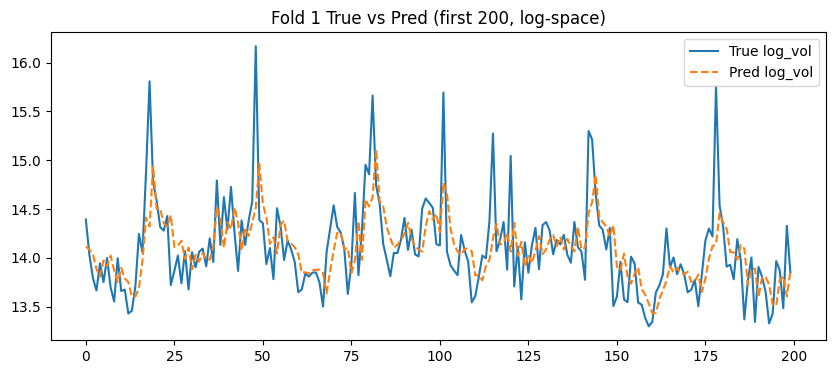


=== Fold 2/5 ===


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2168/2168 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Fold 2 — R² (log-space): 0.9261
Fold 2 — MSE (vol): 22714704442420.0
Fold 2 — MAE (vol): 1224918.0
Fold 2 — R²  (vol): 0.8205
Fold 2 — Base R² (vol): 0.5901


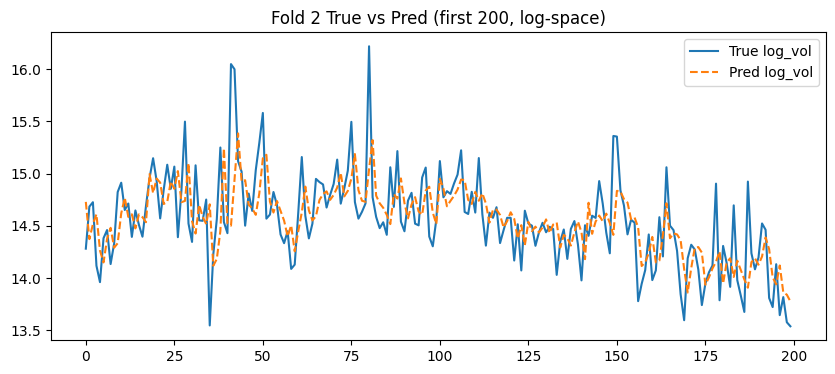


=== Fold 3/5 ===


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2168/2168 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step
Fold 3 — R² (log-space): 0.7178
Fold 3 — MSE (vol): 9476944380248.8
Fold 3 — MAE (vol): 1145719.0
Fold 3 — R²  (vol): 0.7695
Fold 3 — Base R² (vol): 0.4265


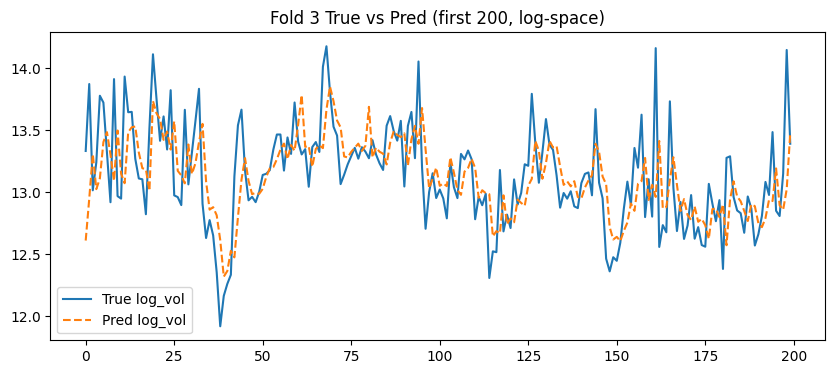


=== Fold 4/5 ===


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2168/2168 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step
Fold 4 — R² (log-space): 0.9261
Fold 4 — MSE (vol): 148926233509319.1
Fold 4 — MAE (vol): 1636971.5
Fold 4 — R²  (vol): 0.4957
Fold 4 — Base R² (vol): 0.6347


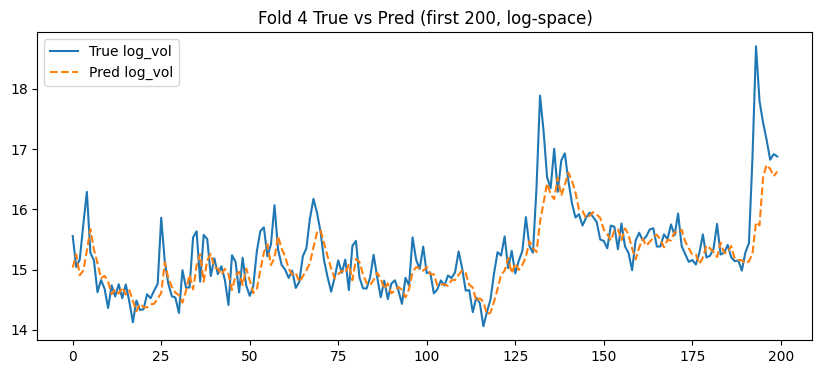


=== Fold 5/5 ===


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2168/2168 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Fold 5 — R² (log-space): 0.7344
Fold 5 — MSE (vol): 22859802149051.8
Fold 5 — MAE (vol): 1372753.1
Fold 5 — R²  (vol): 0.8750
Fold 5 — Base R² (vol): 0.7372


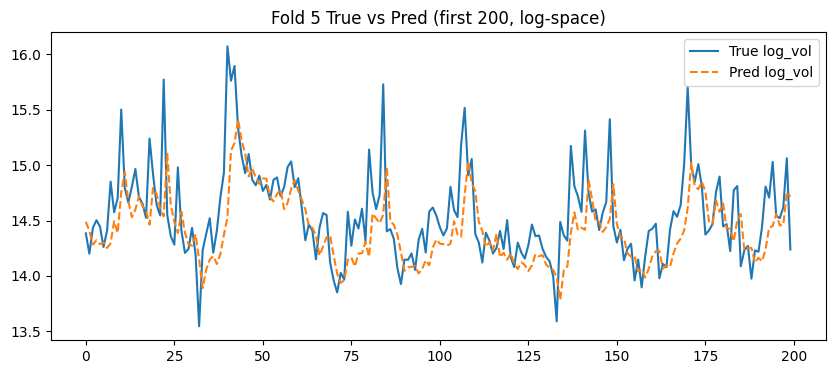

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from tqdm.keras import TqdmCallback

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, Dense, Dropout, concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import LambdaCallback

from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D

from sklearn.model_selection import TimeSeriesSplit

# --- 1) LOAD & SORT
df = pd.read_parquet('data/volume_pred.parquet')
df = df.sort_values(['ticker','date']).reset_index(drop=True)

# --- 2) LOG TARGET
df['log_vol'] = np.log1p(df['VOL'])

# --- 3) LAG FEATURES
window = 10
for lag in tqdm(range(1, window+1), desc='Creating lag features'):
    df[f'lag_{lag}'] = df.groupby('ticker')['log_vol'].shift(lag)

# --- 4) CALENDAR FEATURES
df['weekday']        = df['date'].dt.weekday
df['month']          = df['date'].dt.month
df['is_month_end']   = df['date'].dt.is_month_end.astype(int)
df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)

# --- 5) ROLLING VOLUME STATS
roll_specs = [
    ('vol_ma_7',  7,  'mean'),
    ('vol_ma_21',21, 'mean'),
    ('vol_std_7', 7,  'std'),
    ('vol_std_21',21, 'std')
]
for col_name, sz, func in tqdm(roll_specs, desc='Computing rolling stats'):
    grp = df.groupby('ticker')['VOL']
    if func == 'mean':
        df[col_name] = grp.rolling(sz).mean().shift(1).reset_index(level=0,drop=True)
    else:
        df[col_name] = grp.rolling(sz).std().shift(1).reset_index(level=0,drop=True)

# --- 6) DROP MISSING
feat_cols = [f'lag_{i}' for i in range(1,window+1)] + [
    'weekday','month','is_month_end','is_quarter_end',
    'vol_ma_7','vol_ma_21','vol_std_7','vol_std_21'
]
df.dropna(subset=feat_cols + ['log_vol'], inplace=True)
df.reset_index(drop=True, inplace=True)

# --- 7) BUILD ARRAYS
X_seq    = df[[f'lag_{i}' for i in range(1,window+1)]].values.reshape(-1, window, 1)
X_static = df[['weekday','month','is_month_end','is_quarter_end',
               'vol_ma_7','vol_ma_21','vol_std_7','vol_std_21']].values
y_log    = df['log_vol'].values

# helper to rebuild your model
def build_model(window, n_static):
    seq_in = Input(shape=(window,1), name='seq_input')
    x_seq = Bidirectional(LSTM(64, return_sequences=True))(seq_in)
    attn = MultiHeadAttention(num_heads=4, key_dim=64)(x_seq, x_seq)
    x = GlobalAveragePooling1D()(attn)

    st_in = Input(shape=(n_static,), name='static_input')
    s = Dense(32, activation='relu')(st_in)
    s = Dropout(0.2)(s)

    m = concatenate([x, s])
    m = Dense(64, activation='relu')(m)
    m = Dropout(0.2)(m)
    out = Dense(1, name='log_vol')(m)

    model = Model([seq_in, st_in], out)
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

# set up splits (time-series cross-validation (e.g. TimeSeriesSplit) for more robust error estimates                                                                    )
n_splits = 5
tscv     = TimeSeriesSplit(n_splits=n_splits)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_seq), start=1):
    print(f"\n=== Fold {fold}/{n_splits} ===")

    # ----- slice data -----
    X_seq_tr, X_seq_te = X_seq[train_idx], X_seq[test_idx]
    X_st_tr,  X_st_te  = X_static[train_idx], X_static[test_idx]
    y_tr_log, y_te_log = y_log[train_idx],      y_log[test_idx]

    # ----- scale -----
    scaler_static = StandardScaler().fit(X_st_tr)
    X_st_tr_s = scaler_static.transform(X_st_tr)
    X_st_te_s = scaler_static.transform(X_st_te)

    scaler_y = StandardScaler().fit(y_tr_log.reshape(-1,1))
    y_tr_s   = scaler_y.transform(y_tr_log.reshape(-1,1))
    y_te_s   = scaler_y.transform(y_te_log.reshape(-1,1))

    # ----- TF datasets -----
    train_ds = (
        tf.data.Dataset
          .from_tensor_slices(((X_seq_tr, X_st_tr_s), y_tr_s))
          .shuffle(10_000)
          .batch(32)
          .prefetch(tf.data.AUTOTUNE)
    )
    val_ds = (
        tf.data.Dataset
          .from_tensor_slices(((X_seq_te, X_st_te_s), y_te_s))
          .batch(32)
          .prefetch(tf.data.AUTOTUNE)
    )

    # ----- build & train -----
    model_cv = build_model(window, X_st_tr_s.shape[1])
    es       = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_cv.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[es, TqdmCallback(verbose=1)],
        verbose=0
    )

    # --- 13) PREDICTIONS & INVERT SCALING ----
    y_pred_s   = model_cv.predict(val_ds).flatten()
    y_pred_log = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
    y_base_log = X_seq_te[:,-1,0]  # persistence baseline

    # --- 14) EVALUATION ---
    # compute vol‐space metrics
    y_true_vol = np.expm1(y_te_log)
    y_pred_vol = np.expm1(y_pred_log)
    y_base_vol = np.expm1(y_base_log)

    print(f"Fold {fold} — R² (log-space): {r2_score(y_te_log, y_pred_log):.4f}")
    print(f"Fold {fold} — MSE (vol): {mean_squared_error(y_true_vol, y_pred_vol):.1f}")
    print(f"Fold {fold} — MAE (vol): {mean_absolute_error(y_true_vol, y_pred_vol):.1f}")
    print(f"Fold {fold} — R²  (vol): {r2_score(y_true_vol, y_pred_vol):.4f}")
    print(f"Fold {fold} — Base R² (vol): {r2_score(y_true_vol, y_base_vol):.4f}")

    # --- 15) PLOT FIRST 200 (log-space) for this fold ---
    plt.figure(figsize=(10,4))
    plt.plot(y_te_log[:200],    label='True log_vol')
    plt.plot(y_pred_log[:200], '--', label='Pred log_vol')
    plt.legend()
    plt.title(f"Fold {fold} True vs Pred (first 200, log-space)")
    plt.show()

In [3]:
import pandas as pd

# example: replace these with your real numbers
results = [
    {'fold':1, 'r2_log':0.9093, 'r2_vol':0.7611, 'mae':938765.6},
    {'fold':2, 'r2_log':0.9261, 'r2_vol':0.8205, 'mae':1224918.0},
    {'fold':3, 'r2_log':0.7178, 'r2_vol':0.7695, 'mae':1145719.0},
    {'fold':4, 'r2_log':0.9261, 'r2_vol':0.4957, 'mae':1636971.0},
    {'fold':5, 'r2_log':0.7344, 'r2_vol':0.8750, 'mae':1372753.0}
    # … folds 3–5 …
]

df_res = pd.DataFrame(results)
summary = df_res.describe().loc[['mean','std']]
print(df_res)
print(summary)


   fold  r2_log  r2_vol        mae
0     1  0.9093  0.7611   938765.6
1     2  0.9261  0.8205  1224918.0
2     3  0.7178  0.7695  1145719.0
3     4  0.9261  0.4957  1636971.0
4     5  0.7344  0.8750  1372753.0
          fold    r2_log    r2_vol           mae
mean  3.000000  0.842740  0.744360  1.263825e+06
std   1.581139  0.106859  0.146294  2.608782e+05


In [5]:
import pickle
from tensorflow.keras.models import model_from_json

# 1) Serialize model to JSON + weights to a list
model_json   = model_cv.to_json()
model_weights= model_cv.get_weights()

# 2) Bundle into a dict and pickle it
with open('vol_predictor.pkl', 'wb') as f:
    pickle.dump({
        'model_json':   model_json,
        'model_weights':model_weights
    }, f)

print("Saved model ✔ to vol_predictor.pkl")

NameError: name 'model_cv' is not defined